In [156]:
!git clone https://github.com/Israel-Anaba/Sentiment-Analysis-using-NLP.git


Cloning into 'Sentiment-Analysis-using-NLP'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 68 (delta 25), reused 47 (delta 17), pack-reused 0
Receiving objects: 100% (68/68), 2.07 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [157]:
%cd Sentiment-Analysis-using-NLP


/content/Sentiment-Analysis-using-NLP/Sentiment-Analysis-using-NLP/Sentiment-Analysis-using-NLP/Sentiment-Analysis-using-NLP


# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

Find below a simple example, with just `3 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

### **Package Installation and Importing Libraries**

In [158]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install accelerate>=0.20.1
!pip install transformers[torch]
!pip install wordcloud
!pip install collections-extended
!pip install nltk

In [159]:
import os
import pandas as pd
import string
import re
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import accelerate
import sys
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer
import numpy as np
from sklearn.metrics import f1_score
from datasets import load_metric
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
from google.colab import drive
from huggingface_hub import notebook_login
import warnings
warnings.filterwarnings("ignore")

In [160]:
# Download NLTK resources (you may need to do this the first time)
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [161]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

### **Loading and Preprocessing Data**

In [162]:
# Load the dataset and display some values
df = pd.read_csv('/content/Sentiment-Analysis-using-NLP/asset/Train.csv')

test = pd.read_csv('/content/Sentiment-Analysis-using-NLP/asset/Test.csv')

In [163]:
df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [164]:
df.shape

(10001, 4)

In [165]:
df.info

<bound method DataFrame.info of        tweet_id                                          safe_text  label  \
0      CL1KWCMY  Me &amp; The Big Homie meanboy3000 #MEANBOY #M...    0.0   
1      E3303EME  I'm 100% thinking of devoting my career to pro...    1.0   
2      M4IVFSMS  #whatcausesautism VACCINES, DO NOT VACCINATE Y...   -1.0   
3      1DR6ROZ4  I mean if they immunize my kid with something ...   -1.0   
4      J77ENIIE  Thanks to <user> Catch me performing at La Nui...    0.0   
...         ...                                                ...    ...   
9996   IU0TIJDI  Living in a time where the sperm I used to was...    1.0   
9997   WKKPCJY6  <user> <user>  In spite of all measles outbrea...    1.0   
9998   ST3A265H  Interesting trends in child immunization in Ok...    0.0   
9999   6Z27IJGD  CDC Says Measles Are At Highest Levels In Deca...    0.0   
10000  P6190L3Q  Pneumonia vaccine: for women w risk of pulmona...    1.0   

       agreement  
0       1.000000  
1    

In [166]:
df.describe

<bound method NDFrame.describe of        tweet_id                                          safe_text  label  \
0      CL1KWCMY  Me &amp; The Big Homie meanboy3000 #MEANBOY #M...    0.0   
1      E3303EME  I'm 100% thinking of devoting my career to pro...    1.0   
2      M4IVFSMS  #whatcausesautism VACCINES, DO NOT VACCINATE Y...   -1.0   
3      1DR6ROZ4  I mean if they immunize my kid with something ...   -1.0   
4      J77ENIIE  Thanks to <user> Catch me performing at La Nui...    0.0   
...         ...                                                ...    ...   
9996   IU0TIJDI  Living in a time where the sperm I used to was...    1.0   
9997   WKKPCJY6  <user> <user>  In spite of all measles outbrea...    1.0   
9998   ST3A265H  Interesting trends in child immunization in Ok...    0.0   
9999   6Z27IJGD  CDC Says Measles Are At Highest Levels In Deca...    0.0   
10000  P6190L3Q  Pneumonia vaccine: for women w risk of pulmona...    1.0   

       agreement  
0       1.000000  
1  

In [167]:
df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [168]:
# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

In [169]:
df.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [170]:
test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [171]:
test.shape

(5177, 2)

In [172]:
test.isna().sum()

tweet_id     0
safe_text    1
dtype: int64

In [173]:
# A way to eliminate rows containing NaN values
test = test[~test.isna().any(axis=1)]

In [174]:
test.isna().sum()

tweet_id     0
safe_text    0
dtype: int64

This code creates a bar chart that displays the distribution of labels in our dataset. The x-axis represents the 'Label' values, and the y-axis represents the count of each label. It helps us to visualize how the labels are distributed in our data.

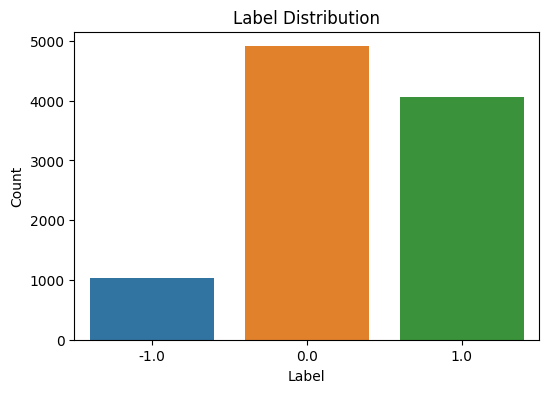

In [175]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()


This plot is useful for understanding the distribution of text lengths in our dataset. It can help identify common text length ranges and potential outliers. For example, we can see that most tweets are between 50 and 150 characters in length, with a peak around 120 characters. Understanding the distribution of text lengths can inform decisions on text preprocessing and modeling choices.

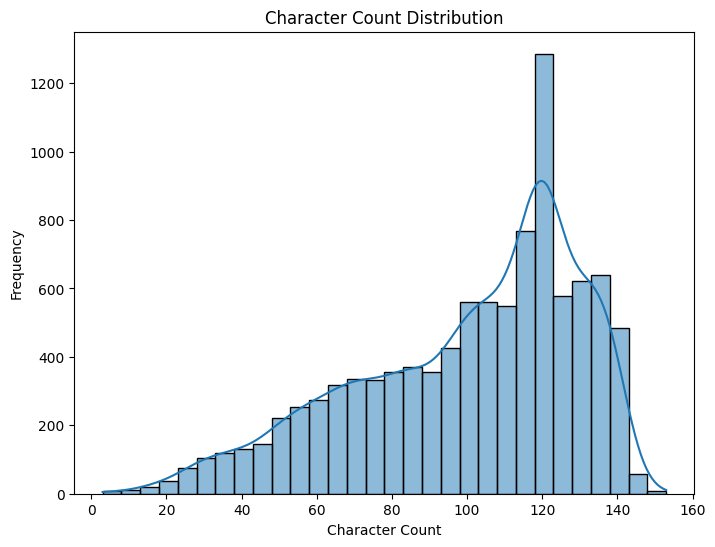

In [176]:
plt.figure(figsize=(8, 6))
df['char_count'] = df['safe_text'].apply(len)
sns.histplot(df['char_count'], bins=30, kde=True)
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Character Count Distribution')
plt.show()
df.drop('char_count', axis=1, inplace=True)  # Remove the temporary column


This plot is useful for gaining insights into the distribution of 'Agreement' values in our dataset. It can help identify common 'Agreement' value ranges and potential outliers. Understanding this distribution is valuable as it provides an overview of the data's characteristics related to the 'Agreement' feature.

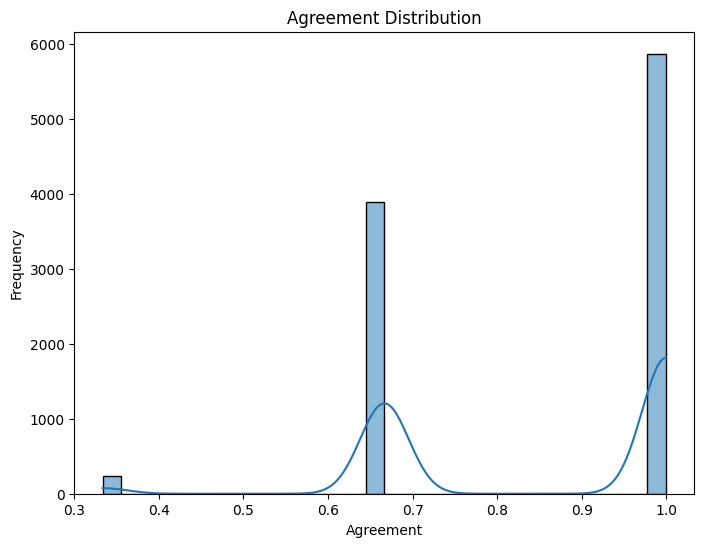

In [177]:
plt.figure(figsize=(8, 6))
sns.histplot(df['agreement'], bins=30, kde=True)
plt.xlabel('Agreement')
plt.ylabel('Frequency')
plt.title('Agreement Distribution')
plt.show()


This plot is valuable for understanding the most common topics or themes present in our text data, as represented by hashtags. It is useful for content analysis, trend identification, and gaining insights into what is being discussed or referenced in your dataset.

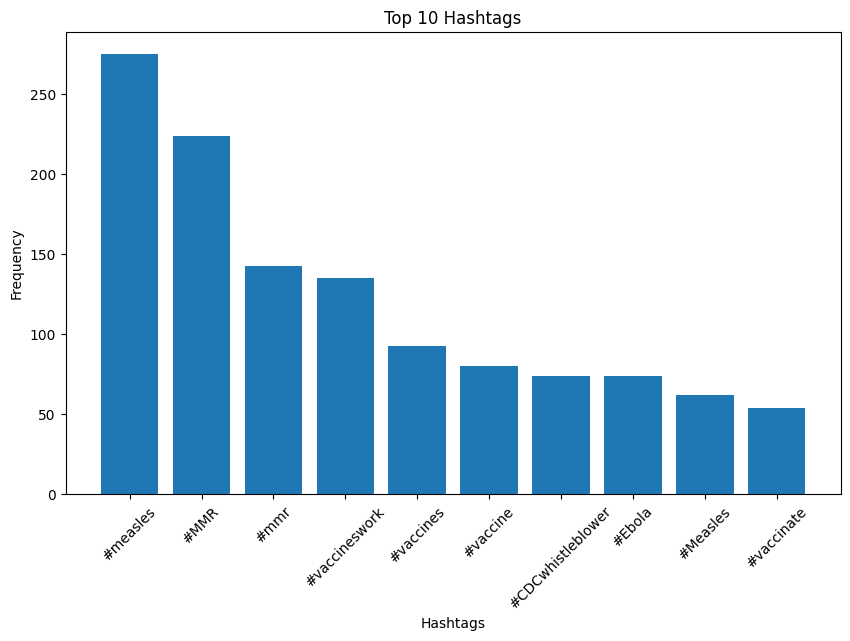

In [178]:
hashtags = df['safe_text'].str.findall(r'#\w+')
hashtags = [item for sublist in hashtags for item in sublist]
hashtag_freq = Counter(hashtags)

# Get the top 20 hashtags
top_10_hashtags = dict(hashtag_freq.most_common(10))

plt.figure(figsize=(10, 6))
plt.bar(top_10_hashtags.keys(), top_10_hashtags.values())
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45)
plt.show()



The resulting heatmap represents the correlation matrix, making it easier to understand the relationships between numerical variables in our DataFrame.

Correlation Values: Each cell in the heatmap contains a numerical value, which represents the correlation coefficient between two variables. The color of each cell indicates the strength and direction of the correlation.

Dark blue or purple shades indicate strong negative correlations.
Dark red or orange shades indicate strong positive correlations.
White or light-colored cells indicate weak or no correlations.

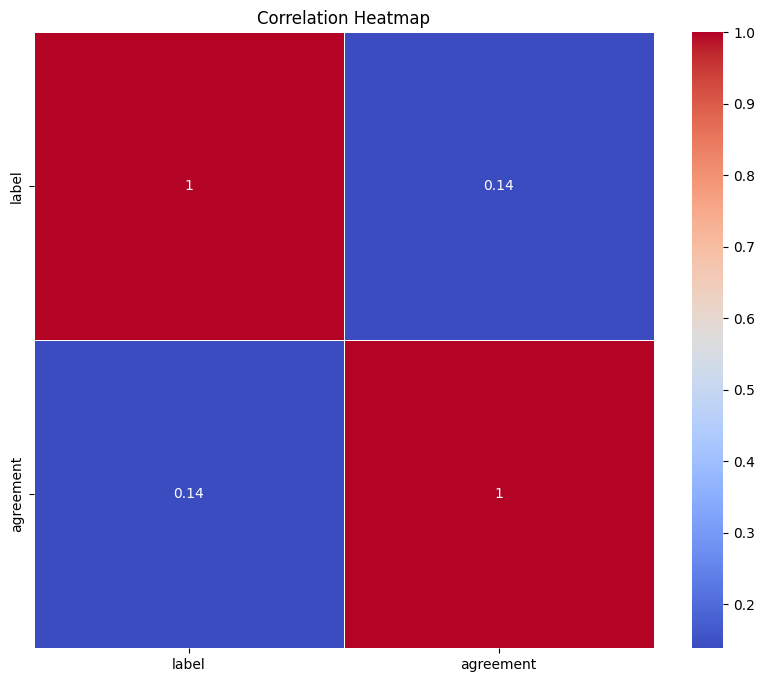

In [179]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


This word cloud helps to quickly identify which terms or words are most prevalent in the 'safe_text' column. It provide insights into the most common themes or topics present in your text data.

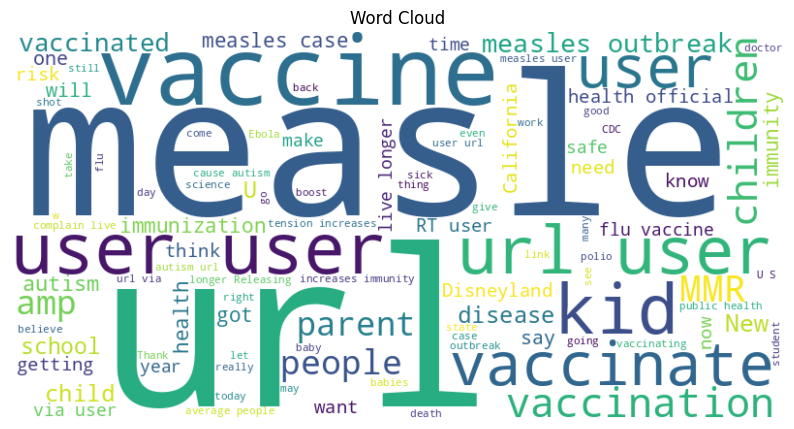

In [180]:
all_text = ' '.join(df['safe_text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


This visualization is useful for quickly identifying the most prevalent terms or stopwords in our text data. It can help us understand the common language used in our dataset and potentially guide preprocessing steps such as stopwords removal or stemming.

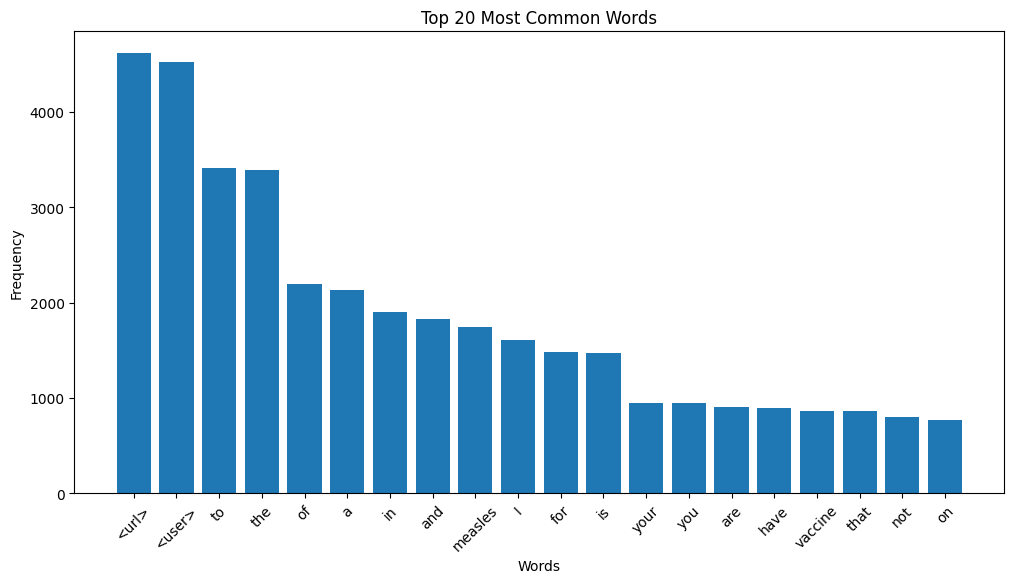

In [181]:
words = ' '.join(df['safe_text']).split()
word_freq = Counter(words)
most_common_words = word_freq.most_common(20)  # Change 20 to the desired number of words
words, frequencies = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.show()


This visualization compares the character count distributions for different labels.

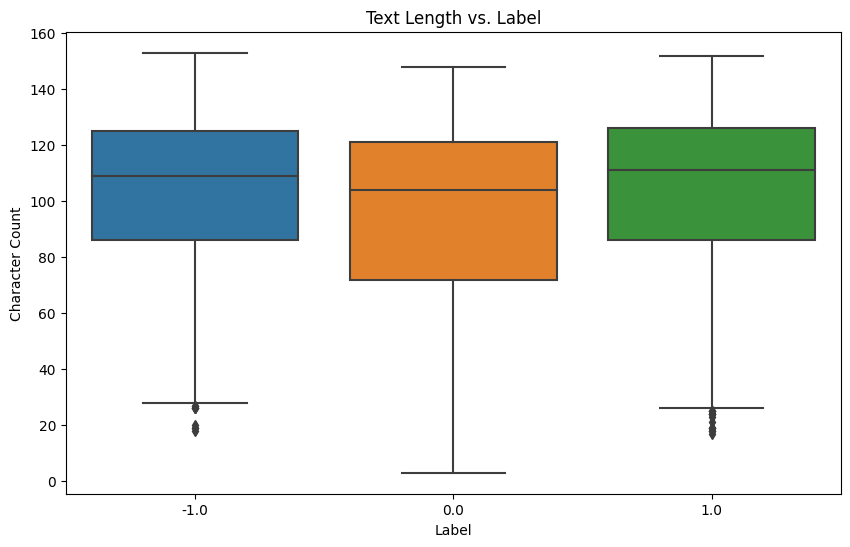

In [182]:
# Calculate the character count for each 'safe_text' and add it as a new column
df['char_count'] = df['safe_text'].apply(len)

# Create a boxplot to visualize text length vs. label
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='char_count', data=df)
plt.xlabel('Label')
plt.ylabel('Character Count')
plt.title('Text Length vs. Label')
plt.show()

# Remove the temporary 'char_count' column
df.drop('char_count', axis=1, inplace=True)

By examining the scatterplots and histograms, we can gather insights into the relationships between variables and how these relationships vary across different label categories. This visualization can help identify patterns, correlations, and differences between labels concerning the numerical variables in our dataset.

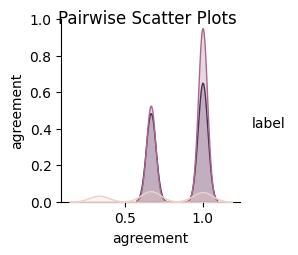

In [183]:
sns.pairplot(df, hue='label', markers=['o', 's', 'D'])
plt.suptitle('Pairwise Scatter Plots')
plt.show()

This bar chart is useful for quickly identifying which words are the most common in your text data. It helps us understand the dominant terms and gain insights into the language and topics prevalent in test dataset.






In [184]:
# Calculate the character count for each 'safe_text' and add it as a new column
test['char_count'] = test['safe_text'].apply(len)

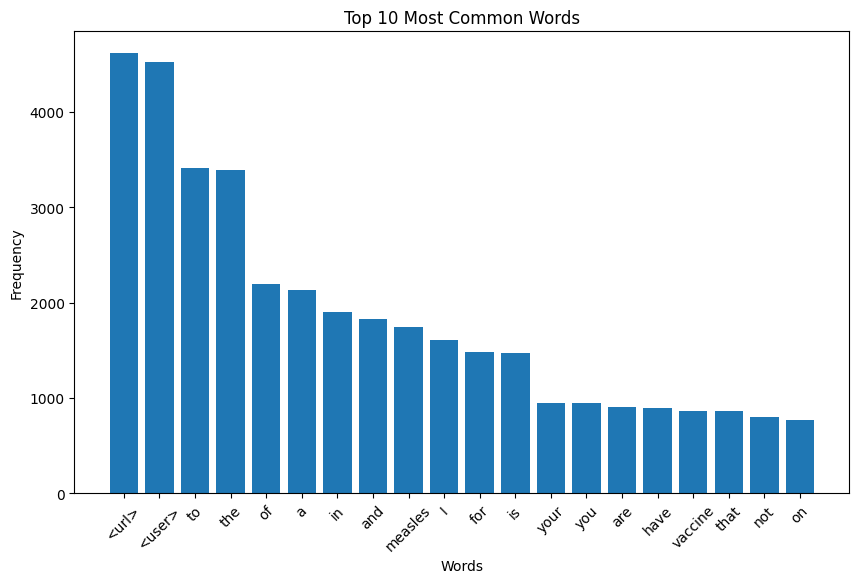

In [185]:
# Bar chart for word frequency
common_words, frequencies = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(common_words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

This histogram is useful for understanding the variation in text length within our dataset. It can help us identify whether our text data has a consistent length or if there is significant variability

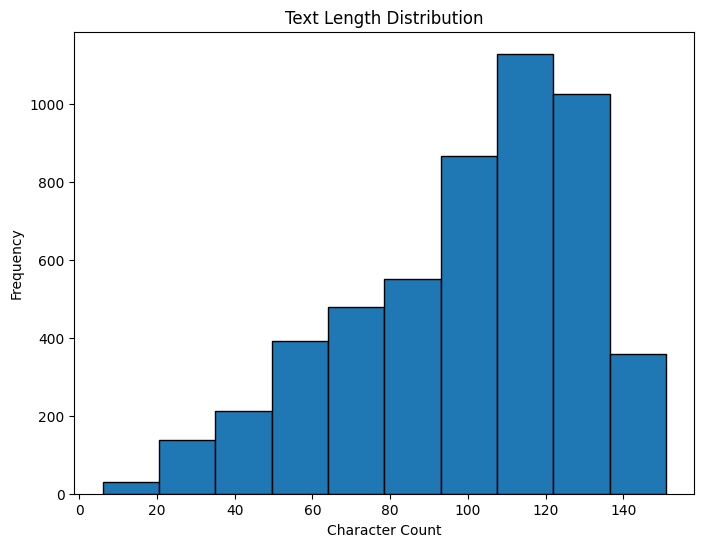

In [186]:
# Text length distribution
plt.figure(figsize=(8, 6))
plt.hist(test['char_count'], bins=10, edgecolor='k')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

I manually split the training set to have a training subset ( a dataset the model will learn on), and an evaluation subset ( a dataset the model with use to compute metric scores to help use to avoid some training problems like [the overfitting](https://www.ibm.com/cloud/learn/overfitting) one ).

There are multiple ways to do split the dataset. You'll see two commented line showing you another one.

In [187]:
def remove_user_url(text):
    cleaned_text = re.sub(r'\b\w*user\w*\b|\b\w*url\w*\b', '', text, flags=re.IGNORECASE)
    return cleaned_text

# Use .loc to explicitly modify the 'safe_text' column in the original DataFrame
df['safe_text'] = df['safe_text'].apply(lambda x: remove_user_url(x))

In [188]:
def remove_special_characters(text):
    # Remove special characters, punctuation, and digits
    cleaned_text = re.sub(r'[^\w\s]|[\d]+', '', text)
    return cleaned_text

# Apply the function to the 'safe_text' column
df['safe_text'] = df['safe_text'].apply(remove_special_characters)

# Assuming your DataFrame is named 'df' and you want to convert the 'safe_text' column to lowercase
df['safe_text'] = df['safe_text'].str.lower()

In [189]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to perform lemmatization on a text
def lemmatize_text(text):
    words = word_tokenize(text)  # Tokenize the text into words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize each word
    return ' '.join(lemmatized_words)  # Join the lemmatized words back into a text

# Apply lemmatization to the 'safe_text' column
df['safe_text'] = df['safe_text'].apply(lemmatize_text)

In [190]:
# # Initialize the Porter Stemmer
# stemmer = PorterStemmer()

# # Function to perform stemming on a text
# def stem_text(text):
#     words = word_tokenize(text)  # Tokenize the text into words
#     stemmed_words = [stemmer.stem(word) for word in words]  # Stem each word
#     return ' '.join(stemmed_words)  # Join the stemmed words back into a text

# # Apply stemming to the 'safe_text' column
# df['safe_text'] = df['safe_text'].apply(stem_text)

In [191]:
# Replace 'vaccin' with 'vaccine' in the 'safe_text' column
# df['safe_text'] = df['safe_text'].str.replace('vaccin', 'vaccine')

In [192]:
# Display a few examples for each sentiment class

# List of unique sentiment labels (positive, neutral, negative)
sentiment_labels = df['label'].unique()

# Define the number of examples to display for each class
num_examples_per_class = 5

# Loop through each sentiment class
for label in sentiment_labels:
    # Filter the DataFrame for samples with the current sentiment label
    samples = df[df['label'] == label]['safe_text'].sample(num_examples_per_class)

    # Display the sentiment label and corresponding text samples
    print(f"Sentiment Label: {label}")
    for i, text in enumerate(samples):
        print(f"Example {i + 1}: {text}\n")

Sentiment Label: 0.0
Example 1: are there measles in arendelle emolyandclaire winterbreakisntcompletewithouther arendelle

Example 2: health official dutch county measles patient took amtrak train

Example 3: my nephew got measles and he keep touching me

Example 4: no measles please downtown disney

Example 5: wa just listening to the vaccine and then went straight to jt so now you know what it like inside my crazy brain realtalk

Sentiment Label: 1.0
Example 1: the reason for all child to be vaccinated have become clear

Example 2: vaccinated measles patient are not good in transmitting the disease when compared to unvaccinated idweek

Example 3: just because you dont see vaccine preventable disease doesnt mean they dont exist prevention work get your kid vaccinated

Example 4: my poor baby is such a trooper she had such a hard time with her vaccine on the plus side she weighs lb oz and is in long

Example 5: i know it crazy there literally no evidence based literature that show any 

In [193]:
df.head(10)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,me amp the big homie meanboy meanboy mb mb mmr...,0.0,1.000000
1,E3303EME,im thinking of devoting my career to proving a...,1.0,1.000000
2,M4IVFSMS,whatcausesautism vaccine do not vaccinate your...,-1.0,1.000000
3,1DR6ROZ4,i mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,thanks to catch me performing at la nuit nyc s...,0.0,1.000000
5,OVNPOAUX,a nearly year old study when mental health stu...,1.0,0.666667
6,JDA2QDV5,study of more than kid find no link between mm...,1.0,0.666667
7,S6UKR4OJ,psa vaccinate your fucking kid,1.0,1.000000
8,V6IJATBE,coughing extra on the shuttle and everyone thi...,1.0,0.666667
9,VB25IDQK,aid vaccine created at oregon health amp scien...,1.0,0.666667


In [194]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=40, stratify=df['label'])

In [195]:
train.head()

,tweet_id,safe_text,label,agreement
3389,HK43EYLX,child receive vaccination before school it wa ...,0.0,0.666667
8635,3BWLQK25,rabid cat capture lead to vaccination reminder...,1.0,0.666667
4406,9KKVJ51T,breaking two suspected measles case being moni...,0.0,1.000000
8624,VOF67NGH,mickey minnie and measles for nine disneyland ...,0.0,0.666667
3454,9B1WHXX5,finally rt california crack down on vaccine ex...,1.0,0.666667


In [196]:
eval.head()

,tweet_id,safe_text,label,agreement
9276,MU0AZP0A,parenting checklist dont vaccinate kid take th...,0.0,0.666667
8805,QHAQXRI9,thought on world autism awareness day from a f...,0.0,1.000000
511,FFJQ2Q4N,so the expenditure of money is comparable to a...,-1.0,0.333333
3290,39EE91VG,more than parent arrested for not allowing the...,1.0,1.000000
6588,PAKFM4QV,city of milwaukee offer measles immunization c...,1.0,0.666667


In [197]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

# Check for duplicates in 'train' dataset
train_duplicates = train[train.duplicated()]
print(f"Number of duplicates in 'train': {len(train_duplicates)}")

# Check for NaN values in 'train' dataset
train_nan = train.isna().sum()
print("NaN counts in 'train':")
print(train_nan)

# Check for duplicates in 'eval' dataset
eval_duplicates = eval[eval.duplicated()]
print(f"Number of duplicates in 'eval': {len(eval_duplicates)}")

# Check for NaN values in 'eval' dataset
eval_nan = eval.isna().sum()
print("NaN counts in 'eval':")
print(eval_nan)

new dataframe shapes: train is (7999, 4), eval is (2000, 4)
Number of duplicates in 'train': 0
NaN counts in 'train':
tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64
Number of duplicates in 'eval': 0
NaN counts in 'eval':
tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64


In [198]:
# Define the directory path
directory = "../content/Sentiment-Analysis-using-NLP/asset"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the subsets to CSV
train.to_csv(os.path.join(directory, "train_subset.csv"), index=False)
eval.to_csv(os.path.join(directory, "eval_subset.csv"), index=False)


In [199]:
notebook_login()

In [200]:
dataset = load_dataset('csv',
                        data_files={'train': '../content/Sentiment-Analysis-using-NLP/asset/train_subset.csv',
                        'eval': '../content/Sentiment-Analysis-using-NLP/asset/eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [201]:
# Load the RoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

In [202]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [203]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [204]:
# dataset['train']

In [205]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# training_args = TrainingArguments("test_trainer", num_train_epochs=2, load_best_model_at_end=True,)

training_args = TrainingArguments(
    "sentiment_analysis",
    num_train_epochs=10,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    push_to_hub=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [206]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [207]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

In [208]:
def compute_f1_score(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1_score": f1}

In [209]:
# Define a function to compute accuracy
metric = load_metric("accuracy")

def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [210]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_f1_score,
    tokenizer=tokenizer,
)

In [211]:
# Launch the learning process: training
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1 Score
1000,0.757700,0.799577,0.660303
2000,0.716800,0.736192,0.662712
3000,0.720100,0.723079,0.667475
4000,0.675200,0.705147,0.697022
5000,0.637400,0.716677,0.700740
6000,0.628800,0.727798,0.719270
7000,0.557900,0.824241,0.719044
8000,0.548500,0.758714,0.729069
9000,0.530900,0.787611,0.726878
10000,0.476700,0.811393,0.732151


TrainOutput(global_step=10000, training_loss=0.6304681884765625, metrics={'train_runtime': 8256.589, 'train_samples_per_second': 9.688, 'train_steps_per_second': 1.211, 'total_flos': 2.104644228406272e+16, 'train_loss': 0.6304681884765625, 'epoch': 10.0})

In [212]:
trainer.push_to_hub()

'https://huggingface.co/IsaacSarps/sentiment_analysis/tree/main/'

In [213]:
model.push_to_hub("sentiment_analysis")

CommitInfo(commit_url='https://huggingface.co/IsaacSarps/sentiment_analysis/commit/cf5fb114e81152e1bd3960abbdb652e7059d7f16', commit_message='Upload RobertaForSequenceClassification', commit_description='', oid='cf5fb114e81152e1bd3960abbdb652e7059d7f16', pr_url=None, pr_revision=None, pr_num=None)

In [214]:
tokenizer.push_to_hub("sentiment_analysis")

CommitInfo(commit_url='https://huggingface.co/IsaacSarps/sentiment_analysis/commit/a3848e9605d96fdb4e55ec6d6c5b4c27d67ceec6', commit_message='Upload tokenizer', commit_description='', oid='a3848e9605d96fdb4e55ec6d6c5b4c27d67ceec6', pr_url=None, pr_revision=None, pr_num=None)

In [215]:
# Launch the final evaluation
eval_metrics = trainer.evaluate()

print("***** Evaluation Metrics *****")
for key, value in eval_metrics.items():
    print(f"{key}: {value}")

***** Evaluation Metrics *****
eval_loss: 0.7051466107368469
eval_f1_score: 0.6970216607254134
eval_runtime: 59.6192
eval_samples_per_second: 33.546
eval_steps_per_second: 4.193
epoch: 10.0


Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

This notebook is inspired by an article: [Fine-Tuning Bert for Tweets Classification ft. Hugging Face](https://medium.com/mlearning-ai/fine-tuning-bert-for-tweets-classification-ft-hugging-face-8afebadd5dbf)

Do not hesitaite to read more and to ask questions, the Learning is a lifelong activity.